In [1]:
import Ipynb_importer
import json
import os
import random
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from model import AlexNet_v1,AlexNet_v2
import matplotlib.pyplot as plt
%matplotlib inline

'''
按照PCI_BUS_ID顺序从0开始排列GPU设备(按设备的PCI Bus ID 为设备分配索引序号)
PCI Bus ID可理解为设备的物理ID
'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 指定使用第1块CPU(如果想让其发现多块CPU，只需要将"0"变为"0,1"即可...)

2022-03-18 18:12:17.400674: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


importing Jupyter notebook from model.ipynb


In [2]:
"""
定义超参数
"""
im_height = 224
im_width = 224
epoch_num = 10
lr = 0.0005
batch_size = 64

In [3]:
"""
默认情况下 TensorFlow 会使用其所能够使用的所有 GPU，这样，会出现浪费的情况
下列代码让其按需申请显存空间
详解：https://blog.csdn.net/dupei/article/details/103369542
"""
gpus = tf.config.experimental.list_physical_devices(device_type="GPU") # 列出当前设备上的GPU和CPU
print(type(gpus))
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        exit(-1)

<class 'list'>
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-18 18:12:18.813185: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-18 18:12:20.017790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 18:12:20.018328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-18 18:12:20.018346: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-18 18:12:20.019563: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-18 18:12:20.020416: I tensorflow/stream_executor

In [4]:
"""
获取数据(实质上是获取训练集和验证集的图片路径)
"""
# 声明data路径
data_root = "./data"

train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')

assert os.path.exists(train_dir), "cannot find {}".format(train_dir)
assert os.path.exists(val_dir), "cannot find {}".format(val_dir)

# 创建文件夹保存模型参数
save_path = "save_weights"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# class dict
data_class = [cla for cla in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, cla))]
class_num = len(data_class)
class_dict = dict((value,index) for index, value in enumerate(data_class))# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}

invert_class_dict = dict((v, k) for k,v in class_dict.items())# {0:'daisy', 1:'dandelion', 2:'roses' 3:'sunflower' 4:'tulips'}

# write dict into json file
with open('class_indices.json', 'w') as json_file:
    json.dump(invert_class_dict, json_file, indent=4)

# 记载训练集图片
train_image_list = glob.glob(os.path.join(train_dir,"*/*.jpg"))
random.shuffle(train_image_list) # 随机打乱
train_num = len(train_image_list)
assert train_num>0, "cannot find any .jpg file in {}".format(train_dir)
train_label_list = [class_dict[path.split(os.path.sep)[-2]] for path in train_image_list] # os.path.sep:获取路径分隔符

# 记载验证集图片
val_image_list = glob.glob(os.path.join(val_dir,"*/*.jpg"))
val_num = len(val_image_list)
assert val_num>0, "cannot find any .jpg file in {}".format(val_dir)
val_label_list = [class_dict[path.split(os.path.sep)[-2]] for path in val_image_list] # os.path.sep:获取路径分隔符

print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 3887 images for training, 430 images for validation.


In [5]:
"""
获取dataset(获取真正的图片数据并转为tensor)
"""

# 根据数据路径获取文件，并进行预处理操作，输出tensor型的image和label
def process_path(img_path, label):
    # 将label转为one-hot编码（因为之后用到的loss函数需要获取one-hot格式的label）
    label = tf.one_hot(label, depth=class_num)
    # 读取图像
    img = tf.io.read_file(img_path)
    # 解码图片（将jpg图片解码为uint8数据类型的tensor）
    img = tf.image.decode_jpeg(img)
    # 图像像素值类型转换（会自动进行[0,1]归一化处理）
    img =tf.image.convert_image_dtype(img, tf.float32)
    # 数据预处理（或增强数据，这一步可自由发挥）
    img = tf.image.resize(img, [im_height, im_width])
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE


# load train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_list, train_label_list))
train_dataset = train_dataset.shuffle(buffer_size=train_num)\
                             .map(process_path, num_parallel_calls=AUTOTUNE)\
                             .repeat().batch(batch_size).prefetch(AUTOTUNE)
# load val dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_list, val_label_list))
val_dataset = val_dataset.shuffle(buffer_size=val_num)\
                             .map(process_path, num_parallel_calls=AUTOTUNE)\
                             .repeat().batch(batch_size)

2022-03-18 18:12:20.129514: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 18:12:20.155758: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3600000000 Hz
2022-03-18 18:12:20.157134: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c869214660 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-18 18:12:20.157159: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-18 18:12:20.217773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

In [6]:
for batch_img, batch_label in train_dataset:
    print(len(batch_img))
    print(len(batch_label))
    break

64
64


0.0 0.99985
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
64


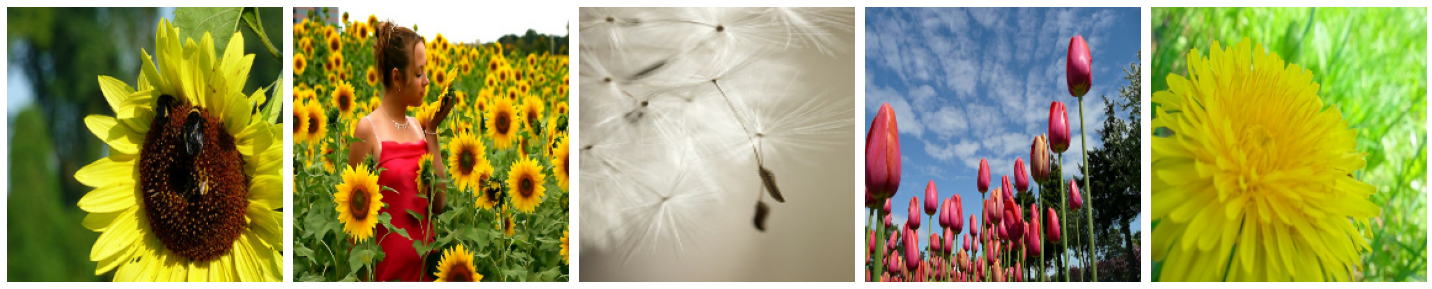

In [7]:
"""
展示图片数据
"""
def plotImgs(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

for train_imgs_batch, train_labels_batch in train_dataset:
    
    print(np.min(train_imgs_batch[0]), np.max(train_imgs_batch[0]))
    
    plotImgs(train_imgs_batch[:5])
    print(train_labels_batch[:5])
    print(len(train_labels_batch))
    break

In [8]:
def showAcc(epoch_num, train_acc,val_acc):
    plt.figure()
    plt.plot(range(epoch_num),train_acc,label="train_acc")
    plt.plot(range(epoch_num),val_acc,label="val_acc")
    plt.xlabel("epochs")
    plt.ylabel("Acc")
    plt.title('Accurary:AlexNet in flowers')
    plt.xticks([i for i in range(0,epoch_num,20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/AccOfAlexNet_gpu.jpg")
    return
def showLoss(epoch_num, train_loss,val_loss):
    plt.figure()
    plt.plot(range(epoch_num),train_loss,label="train_loss")
    plt.plot(range(epoch_num),val_loss,label="val_loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Loss:AlexNet in flowers')
    plt.xticks([i for i in range(0,epoch_num,20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/LossOfAlexNet_gpu.jpg")
    return

# Using keras high level api for traing

In [9]:
def main1():
    """
    获取模型1实例
    """
    model = AlexNet_v1(im_height=im_height, im_width=im_width, num_class=5)
#     model.summary()

    """
    【using keras high level api for traing】
    model.compile详解：https://blog.csdn.net/yunfeather/article/details/106461754
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                 metrics=["accuracy"])
    
    """
    0.callbacks详解：https://www.cnblogs.com/xiximayou/p/12689955.html
    1.save_best_only=True:指标表现最佳时才执行保存模型参数操作（指标—monitor='val_losss'，即当val_loss最小时保存）；
    2.save_weights_only=True：只保留模型参数，体积较小
    （1）为False时表示既保存参数还保存模型架构，体积较大；
    （2）只保留参数时，后续想要迁移该参数，需要重新定义模型，然后加载该参数；
    （3）既保存参数还保存模型架构时，后续可直接加载该保存文件，返回model。
    """
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./save_weights/myAlexNet_gpu.h5',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   monitor='val_loss')]

    history = model.fit(x=train_dataset,
                     steps_per_epoch=train_num // batch_size,
                     epochs=epoch_num,
                     validation_data=val_dataset,
                     validation_steps=val_num // batch_size,
                     callbacks=callbacks)
    
    """
    plot losss and accuracy image
    """
    history_dict = history.history
    train_loss = history_dict['loss']
    train_accuracy = history_dict['accuracy']
    val_loss = history_dict['val_loss']
    val_accuracy = history_dict['val_accuracy']
    
    showAcc(epoch_num=epoch_num, train_acc=train_accuracy, val_acc=val_accuracy)
    showLoss(epoch_num=epoch_num, train_loss=train_loss, val_loss=val_loss)

In [10]:
# main()

In [11]:
"""
定义绘图参数
"""
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

"""
获取模型2实例
注：Using keras high level api for traing 或 Using keras low level api for traing与用模型1还是模型2无关
此处只是分别使用一下两种模型进行实例化进行演示（即此处也可继续使用模型1实例化对象）
"""
model = AlexNet_v2(num_classes=5)
model.build((batch_size, im_height, im_width, 3))
model.summary()

"""
定义损失函数
SparseCategoricalCrossentropy讲解 :http://www.360doc.com/content/22/0109/12/32196507_1012511560.shtml
"""
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
"""
定义优化器
"""
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

"""
定义训练过程每一轮loss和accuracy的计算方法
"""
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

"""
定义测试过程每一轮loss和accuracy的计算方法
"""
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Model: "alex_net_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 6, 6, 128)           945856    
_________________________________________________________________
sequential_1 (Sequential)    (64, 5)                   4851461   
Total params: 5,797,317
Trainable params: 5,797,317
Non-trainable params: 0
_________________________________________________________________


In [12]:
"""
@tf.function装饰器（构造高效的python代码）
将python代码转为tensorflow的图结构，能够在GPU、TPU上运算
详解：https://www.bilibili.com/read/cv12856573
"""
# 定义训练函数
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradient = tape.gradient(loss, model.trainable_variables)#将loss反向传播到模型中每一个可训练参数中
    optimizer.apply_gradients(zip(gradient, model.trainable_variables)) #根据梯度更新可训练参数的值
    
    train_loss(loss) # 计算该epoch的loss
    train_accuracy(labels, predictions) #计算该epoch的准确率

# 定义测试函数(注：测试过程不需要进行反向传播)
@tf.function
def test_step(images, labels):
    predictions = model(images)
    loss = loss_object(labels, predictions)
    
    test_loss(loss) # 计算该epoch的loss
    test_acc = test_accuracy(labels, predictions) #计算该epoch的准确率

In [13]:
# 定义main()函数
def main2():
    best_test_acc = 0.0
    for epoch in range(epoch_num):
        # 清零
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for index, (images, labels) in enumerate(train_dataset):
            if (index + 1) == train_num // batch_size:
                break
            train_step(images, labels)
        
        # 记录当前epoch下训练过程的accuracy和loss，为绘图做准备
        train_acc_list.append(train_accuracy.result())
        train_loss_list.append(train_loss.result())
        
        for index, (images, labels) in enumerate(val_dataset):
            if (index + 1) == val_num // batch_size:
                break
            test_step(images, labels)
            
        # 记录当前epoch下验证过程的accuracy和loss，为绘图做准备
        val_acc_list.append(test_accuracy.result())
        val_loss_list.append(test_loss.result())
        
        
        template = "Epoch:{}\nTrain Loss:{}, Train Accuracy:{}%\nTest Loss:{}, Test Accuracy:{}%."
        print(template.format(
            epoch + 1,
            train_loss.result(),
            train_accuracy.result() * 100,
            test_loss.result(),
            test_accuracy.result() * 100
        ))
    
        if test_accuracy.result() > best_test_acc:
            best_test_acc = test_accuracy.result()
            model.save_weights("./save_weights/myAlexNet.ckpt", save_format='tf')
    
    print(f"[Best Test Accuracy]:{(best_test_acc * 100):3f}%")
    showAcc(epoch_num=epoch_num, train_acc=train_acc_list, val_acc=val_acc_list)
    showLoss(epoch_num=epoch_num, train_loss=train_loss_list, val_loss=val_loss_list)

2022-03-18 18:12:21.939463: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-18 18:12:22.100155: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


Epoch:1
Train Loss:1.4541430473327637, Train Accuracy:34.533897399902344%
Test Loss:1.2683031558990479, Test Accuracy:40.3125%.
Epoch:2
Train Loss:1.22602117061615, Train Accuracy:46.92796325683594%
Test Loss:1.0470186471939087, Test Accuracy:55.624996185302734%.
Epoch:3
Train Loss:1.0425019264221191, Train Accuracy:57.2298698425293%
Test Loss:0.887285590171814, Test Accuracy:65.625%.
Epoch:4
Train Loss:0.9744261503219604, Train Accuracy:59.98411178588867%
Test Loss:0.8245046734809875, Test Accuracy:64.0625%.
Epoch:5
Train Loss:0.917493999004364, Train Accuracy:63.87711715698242%
Test Loss:0.8545260429382324, Test Accuracy:65.0%.
Epoch:6
Train Loss:0.8394368290901184, Train Accuracy:66.7637710571289%
Test Loss:0.825840950012207, Test Accuracy:67.5%.
Epoch:7
Train Loss:0.8097848892211914, Train Accuracy:68.85592651367188%
Test Loss:0.7573574781417847, Test Accuracy:70.3125%.
Epoch:8
Train Loss:0.7499549984931946, Train Accuracy:70.52436828613281%
Test Loss:0.817752480506897, Test Accura

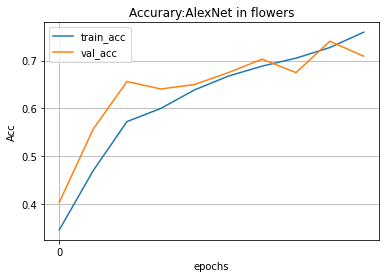

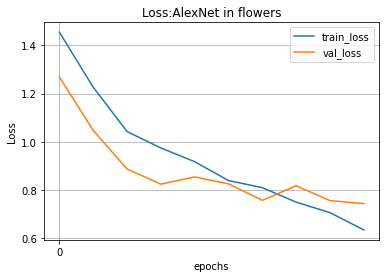

In [14]:
main2()